## Using multicore TPU to accelerate Neural Network Trianing





**Step 1.**
Install the pytorch XLA libreries to communicate with the TPU





In [1]:
import os
assert os.environ['COLAB_TPU_ADDR'], 'Make sure to select TPU from Edit > Notebook settings > Hardware accelerator'

In [2]:
!pip install cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.8-cp37-cp37m-linux_x86_64.whl

     |████████████████████████████████| 144.6MB 31kB/s 
     |████████████████████████████████| 61kB 3.3MB/s 
ERROR: earthengine-api 0.1.260 has requirement google-api-python-client<2,>=1.12.1, but you'll have google-api-python-client 1.8.0 which is incompatible.
  Found existing installation: google-api-python-client 1.12.8
    Uninstalling google-api-python-client-1.12.8:
      Successfully uninstalled google-api-python-client-1.12.8


In [3]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,random_split
from torch.utils.data.distributed import DistributedSampler
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA
import pickle

# import torch xla APIs

import torch_xla
import torch_xla.core.xla_model as xm
import torch_xla.distributed.parallel_loader as pl
import torch_xla.distributed.xla_multiprocessing as xmp

In [ ]:
#train_size=int(0.4*(unprocessed_data.shape[0]))
# val_size=len(unprocessed_data) - train_size
# print(train_size,val_size)
# train_ds,_ = random_split(unprocessed_data,[train_size,val_size])

**Step 2.** Get the dataset

---



In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#cd /content/drive/MyDrive/1780_to_4047_files

In [ ]:
#ls -lsrt

In [5]:
#train_dataset = unscaled[unscaled[:,0] < 2.0]
train_dataset = pickle.load(open('/content/drive/MyDrive/1780_to_4047_files/all_clw_1780_4047_reshaped.pkl','rb'))

In [ ]:
np.max(train_dataset,axis=0) #- np.min(train_dataset,axis=0)

In [15]:
pca_whiten = PCA(whiten=True)

whitten_dataset = pca_whiten.fit_transform(train_dataset[:,:])

In [23]:
def center(X):
    return X - np.mean(X,axis=0)

def whiten(X):
    XCentered = center(X)
    cov = XCentered.T.dot(XCentered)/float(XCentered.shape[0])
    # Calculate the eigenvalues and eigenvectors of the covariance matrix
    eigVals, eigVecs = np.linalg.eig(cov)
    # Apply the eigenvectors to X
    decorrelated = X.dot(eigVecs)
    # Rescale the decorrelated data
    whitened = decorrelated / np.sqrt(eigVals + 1e-5)
    return whitened

In [ ]:
whiten_data = whiten(train_dataset)

In [22]:
XCentered.shape[0]

2252250

In [17]:
np.max(whitten_dataset,axis=0)# - np.min(whitten_dataset,axis=0)

array([   2.65436378,    4.62539069,    4.75660112,    4.89741416,
          4.82003026,    5.22120793,    4.88473406,    4.7028304 ,
          4.92127842,    5.16140401,    4.75802432,    5.15588381,
          4.91587937,    4.91945672,    4.99713203,    4.71877226,
          5.39014005,    4.99685649,    4.99483041,    4.75583957,
          4.76820388,    4.76130856,    4.94157291,    5.09289713,
          5.02150939,    5.32108651,    5.29290873,    5.06507145,
          4.9917627 ,    5.63341593,    5.06305805,    4.90235489,
          5.138628  ,    4.95537282,    5.05363385,    4.65945685,
          4.87134485,    4.8966786 ,    4.62667837,    4.81760421,
          5.10361393,    5.14424619,    4.87609796,    5.05823419,
          4.85378076,    4.70398677,    4.76442443,    4.69866293,
          4.96158803,    4.76395079,    5.38339873,    4.93082973,
          4.99460685,    5.20196971,    5.06888357,    4.8104084 ,
          5.27042953,    4.81001066,    4.93422105,    5.48551

In [ ]:
#train_dataset = torch.from_numpy(train_dataset)

In [ ]:
#train_dataset =  torch.load('/content/drive/MyDrive/Autoencoding/raw_cv_whiten.pt')
#torch.save(train_dataset,'xyz_traj_whitten.pt')

train_dataset = torch.load('/content/drive/MyDrive/1780_to_4047_files/xyz_traj_whitten.pt')

In [ ]:
#train_dataset = train_dataset[:50000]

In [ ]:
train_dataset.shape

torch.Size([2252250, 306])

In [ ]:
# Define Parameters
FLAGS = {}
#FLAGS['data_dir'] = "/tmp/cifar"
FLAGS['batch_size'] = 1028
FLAGS['num_workers'] = 4
FLAGS['max_learning_rate'] = 0.001
#FLAGS['grad_clip']  = 0.1
FLAGS['weight_decay'] = 1e-4
FLAGS['opt_func']  = torch.optim.Adam
#FLAGS['momentum'] = 0.9
FLAGS['num_epochs'] = 10
FLAGS['num_cores'] = 8 
FLAGS['log_steps'] = 20
FLAGS['metrics_debug'] = False

** warp the dataloader for parallelization**

In [ ]:
#SERIAL_EXEC = xmp.MpSerialExecutor()

In [ ]:
#train_dl = DataLoader(train_ds,batch_size,shuffle=True)

In [ ]:
# def make_4_dim(data):
#     data=torch.unsqueeze(data,1)
#     data = torch.unsqueeze(data,3)
#     return data

# def make_2_dim(data):
#     data=torch.squeeze(data,1)
#     data = torch.squeeze(data,2)
#     return data

In [ ]:
def lin_block(in_dim,out_dim,bias=True):
    layers = [nn.Linear(in_dim,out_dim,bias= True),
              #nn.BatchNorm2d(out_dim),
              nn.LeakyReLU(negative_slope=0.2,inplace=True)]
    return nn.Sequential(*layers)

# def conv_block2(in_channels,out_channels,kernel_size,stride,padding,pool=False):
#     layers = [nn.Linear(in_channels=in_channels,out_channels=out_channels,kernel_size=kernel_size,
#                         stride=stride,padding=padding),
#               nn.BatchNorm2d(out_channels),
#               nn.LeakyReLU(negative_slope=0.2,inplace=True)]
#     return nn.Sequential(*layers)
    


In [ ]:
hidden_layers = [256,128,64]
in_dim = 306
lat_dim = 4

In [ ]:
#block = nn.Linear(hidden_layers[1],306,bias = True)

In [ ]:
#out = block(out)

In [ ]:
#out.shape

torch.Size([50000, 306])

In [ ]:
class Resnet9(nn.Module):
      def __init__(self, in_dim,lat_dim,hidden_layers):
        super().__init__()
        
        # Encode
        
        self.lin1 = lin_block(in_dim,hidden_layers[0])     # 306 * 256   
        self.lin2 = lin_block(hidden_layers[0],hidden_layers[1])  # 256 * 128
        self.lin3 = lin_block(hidden_layers[1],hidden_layers[2])  # 128 * 64
        
        self.res1 = nn.Sequential(lin_block(hidden_layers[2], hidden_layers[2]),  # 64 * 64
                                  lin_block(hidden_layers[2], hidden_layers[2]))  # 64 *64
        
        # last layer with on activation function
        self.lin4 = nn.Linear(hidden_layers[2],lat_dim)  # 64 *4
        
        
         # Decode
        
        self.lin5 = lin_block(lat_dim,hidden_layers[2])            # 4 * 64
        self.lin6 = lin_block(hidden_layers[2],hidden_layers[1])   # 64 * 128
        self.res2 = nn.Sequential(lin_block(hidden_layers[1], hidden_layers[1]),  # 128 *128  
                                  lin_block(hidden_layers[1], hidden_layers[1]))
        self.lin7 = lin_block(hidden_layers[1],hidden_layers[0])     # 128 * 256
        self.lin8 = nn.Linear(hidden_layers[0],in_dim)               # 256 * 306
        
        
      def encode(self,in_data):
          out = self.lin1(in_data.float())
          out = self.lin2(out)
          out = self.lin3(out)
          out = self.res1(out)+out
          out = self.lin4(out)
          return out
           
      def decode(self,lat_data):
          out = self.lin5(lat_data.float())
          out = self.lin6(out)
          out = self.res2(out)+out
          out = self.lin7(out)
          out = self.lin8(out)
          return out
      
        

In [ ]:
WRAPPED_MODEL = xmp.MpModelWrapper(Resnet9(in_dim,lat_dim,hidden_layers))

In [ ]:
# # def get_default_device():
# #     """Pick GPU if available, else CPU"""
# #     if torch.cuda.is_available():
# #         return torch.device('cuda')
# #     else:
# #         return torch.device('cpu')
    
# def to_device(data, device):
#     """Move tensor(s) to chosen device"""
#     if isinstance(data, (list,tuple)):
#         return [to_device(x, device) for x in data]
#     return data.to(device, non_blocking=True)

# class DeviceDataLoader():
#     """Wrap a dataloader to move data to a device"""
#     def __init__(self, dl, device):
#         self.dl = dl
#         self.device = device
        
#     def __iter__(self):
#         """Yield a batch of data after moving it to device"""
#         for b in self.dl: 
#             yield to_device(b, self.device)

#     def __len__(self):
#         """Number of batches"""
#         return len(self.dl)

In [ ]:
lag = 8
train_data = train_dataset[:-lag]
shifted_train_data = train_dataset[lag:]
transformed_train_data = torch.hstack((train_data,shifted_train_data))

In [ ]:
#transformed_train_data[:,0]

tensor([-0.3671, -0.3589, -0.3875,  ..., -0.3273, -0.2880, -0.3077],
       dtype=torch.float64)

In [ ]:
def training_step(data,encoder):
    training_dat = data[:,0:306]
    #training_dat = make_4_dim(training_dat)
    shifted_dat = data[:,306:612]
    out = encoder.encode(training_dat)
    out = encoder.decode(out)
    #out = make_2_dim(out)
    criterion = nn.MSELoss()
    loss = criterion(out.float(),shifted_dat.float())
    return loss

In [ ]:
# def training_step(data,encoder):
#     training_dat = data
#     training_dat = make_4_dim(training_dat)
#     out = encoder.encode(training_dat)
#     out = encoder.decode(out)
#     out = make_2_dim(out)
#     criterion = nn.MSELoss()
#     loss = criterion(out.float(),data.float())
#     return loss

# def evaluate(model,val_loader):
#     for data in val_loader:
#         val_dat = data
#         val_dat = make_4_dim(val_dat)
#         out = model.encode(val_dat)
#         out = model.decode(out)
#         out = make_2_dim(out)
#         criterion = nn.MSELoss()
#         loss = criterion(out.float(),data.float())
#         return {'val_loss':loss}

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
# def prepare_data(unprocessed_data):

#       train_ds = unprocessed_data[:]
#       train_ds = train_ds -torch.mean(train_ds,0) # Mean free

#       pca_whiten = PCA(whiten=True)                     # Whiten data
#       train_ds = pca_whiten.fit_transform(train_ds)

#       train_ds = torch.tensor(train_ds)                  # as tensor
#       return train_ds

In [ ]:
#@torch.no_grad()
def fit_one_cycle(FLAGS):
    
    torch.manual_seed(1234)
    history = []

    

    #train_dataset = SERIAL_EXEC.run(prepare_data(unprocessed_data))
    #train_dataset = prepare_data(unprocessed_data)
    train_sampler = DistributedSampler(transformed_train_data,
                                       num_replicas=xm.xrt_world_size(),
                                       #num_replicas=8,
                                       rank= xm.get_ordinal(),
                                       shuffle=True)
    train_loader  = DataLoader(transformed_train_data,
                               batch_size=FLAGS['batch_size'],
                               sampler= train_sampler,
                               num_workers=FLAGS['num_workers'])
    
    # Scale learning rate to no of torch devices
    max_lr = FLAGS['max_learning_rate']*xm.xrt_world_size()

    # Get loss function, optimizer, and model
    device = xm.xla_device()
    encoder = WRAPPED_MODEL.to(device)
    opt_func = FLAGS['opt_func']
    # set up custom optimizer with weight decay
    optimizer = opt_func(encoder.parameters(),
                         FLAGS['max_learning_rate'],
                         weight_decay=FLAGS['weight_decay'])
    
    # set up one_cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer,
                                                FLAGS['max_learning_rate'],
                                               epochs=FLAGS['num_epochs'],
                                               steps_per_epoch=len(train_loader))
    
    
    # crate the loop for training
    
    for epoch in range(FLAGS['num_epochs']):
        # Training Phase
        encoder.train()
        train_losses = []
        para_loader = pl.ParallelLoader(train_loader,[device]).per_device_loader(device)
        #train_loop_fn(para_loader.per_device_loader(device))
        xm.master_print("Finished training epoch {}".format(epoch))
        
        for batch in tqdm(para_loader):
            
            loss = training_step(batch,encoder)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            #if grad_clip:
            #nn.utils.clip_grad_value_(encoder.parameters(),
            #                             FLAGS['grad_clip'])
            xm.optimizer_step(optimizer)
            optimizer.zero_grad()
            
            sched.step()
        # Validation Phase    
        #result = evaluate(model,val_loader)
        train_loss = torch.stack(train_losses).mean().item()
        print('train_loss{:.4f}'.format(train_loss))
        history.append(train_loss)
        history_ten = torch.tensor(history)
        xm.save(encoder.state_dict(),'encoder_state_dict_resnet.pth')
        xm.save(history_ten,'history_resnet.pth')
    return history_ten

In [ ]:
# train_sampler = DistributedSampler(transformed_train_data,
#                                        num_replicas=xm.xrt_world_size(),
#                                        #num_replicas=8,
#                                        rank= xm.get_ordinal(),
#                                        shuffle=True)
# train_loader  = DataLoader(transformed_train_data,
#                                batch_size=FLAGS['batch_size'],
#                                sampler= train_sampler,
#                                num_workers=FLAGS['num_workers'])
# for batch in train_loader:
#     print(batch.shape)
#     break

## Make the Map Function 

In [ ]:
#torch.unsqueeze(batch,dim=0).shape

In [ ]:
def map_fn(rank,flags):
    global FLAGS
    FLAGS = flags 
    torch.set_default_tensor_type('torch.FloatTensor')
    #history = []
    history_ten = fit_one_cycle(FLAGS)
    # if rank == 0:
    # # Retrieve tensors that are on TPU core 0 and plot.
    #    xm.save(encoder_state_dict,'encoder_state_dict.pth')

if __name__ == '__main__':
          xmp.spawn(map_fn,args = (FLAGS,),nprocs=FLAGS['num_cores'],
          start_method='fork')

Finished training epoch 0










train_loss0.9841
train_loss0.9842
train_loss0.9840
train_loss0.9842
train_loss0.9838
train_loss0.9839
train_loss0.9840
train_loss0.9836
Finished training epoch 1










train_loss0.9839
train_loss0.9837
train_loss0.9839
train_loss0.9838
train_loss0.9837
train_loss0.9833
train_loss0.9835
train_loss0.9836
Finished training epoch 2










train_loss0.9839
train_loss0.9833
train_loss0.9839
train_loss0.9838
train_loss0.9835
train_loss0.9836
train_loss0.9837
train_loss0.9837
Finished training epoch 3










train_loss0.9833
train_loss0.9839
train_loss0.9835
train_loss0.9837
train_loss0.9836
train_loss0.9838
train_loss0.9839
train_loss0.9837
Finished training epoch 4










train_loss0.9837
train_loss0.9836
train_loss0.9833
train_loss0.9839
train_loss0.9839
train_loss0.9837
train_loss0.9838
train_loss0.9835
Finished training epoch 5










train_loss0.9837
train_loss0.9839
train_loss0.9839
train_loss0.9837
train_loss0.9835
train_loss0.9836
train_loss0.9833
train_loss0.9838
Finished training epoch 6










train_loss0.9833
train_loss0.9839
train_loss0.9837
train_loss0.9839
train_loss0.9837
train_loss0.9838
train_loss0.9836
train_loss0.9835
Finished training epoch 7










train_loss0.9839
train_loss0.9833
train_loss0.9835
train_loss0.9838
train_loss0.9836
train_loss0.9837
train_loss0.9837
train_loss0.9839
Finished training epoch 8










train_loss0.9833
train_loss0.9836
train_loss0.9837
train_loss0.9838
train_loss0.9839
train_loss0.9837
train_loss0.9839
train_loss0.9835
Finished training epoch 9










train_loss0.9833
train_loss0.9838
train_loss0.9835
train_loss0.9837
train_loss0.9839
train_loss0.9836
train_loss0.9837
train_loss0.9839


In [ ]:
mkdir /content/drive/MyDrive/1780_to_4047_files/model_state_dict

In [ ]:
mv encoder_state_dict_resnet.pth history_resnet.pth /content/drive/MyDrive/1780_to_4047_files/model_state_dict

device(type='xla', index=1)

In [ ]:
# def train(rank, flags):
#     torch.manual_seed(1234)

#     device = xm.xla_device()  
#     t = torch.randn((2, 2), device=device)
    
#     print("Process", rank ,"is using", xm.xla_real_devices([str(device)])[0])



# flags = {}
# xmp.spawn(train, args=(flags,), nprocs=1, start_method='fork')

Process 0 is using TPU:0


In [ ]:
history = torch.load('/content/drive/MyDrive/1780_to_4047_files/model_state_dict/history_resnet.pth')

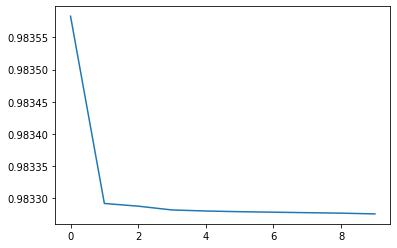

In [ ]:
plt.plot(history)
plt.xlabel = ('Epochs')
plt.ylabel = ('MSE_loss')
plt.savefig('loss.png')

In [ ]:
mv loss.png /content/drive/MyDrive/1780_to_4047_files/model_state_dict

In [ ]:
decoder.load_state_dict(torch.load('encoder_state_dict.pth'))
encoder.load_state_dict(torch.load('encoder_state_dict_1.pth'))

In [ ]:
torch.all(torch.eq(decoder.state_dict(),encoder.state_dict()))